In [1]:
!pip install ultralytics

from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
from ultralytics import YOLO
import numpy as np
import base64
import io
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


<IPython.core.display.Javascript object>

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 1.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


0: 384x640 1 person, 556.2ms
Speed: 19.6ms preprocess, 556.2ms inference, 36.7ms postprocess per image at shape (1, 3, 384, 640)


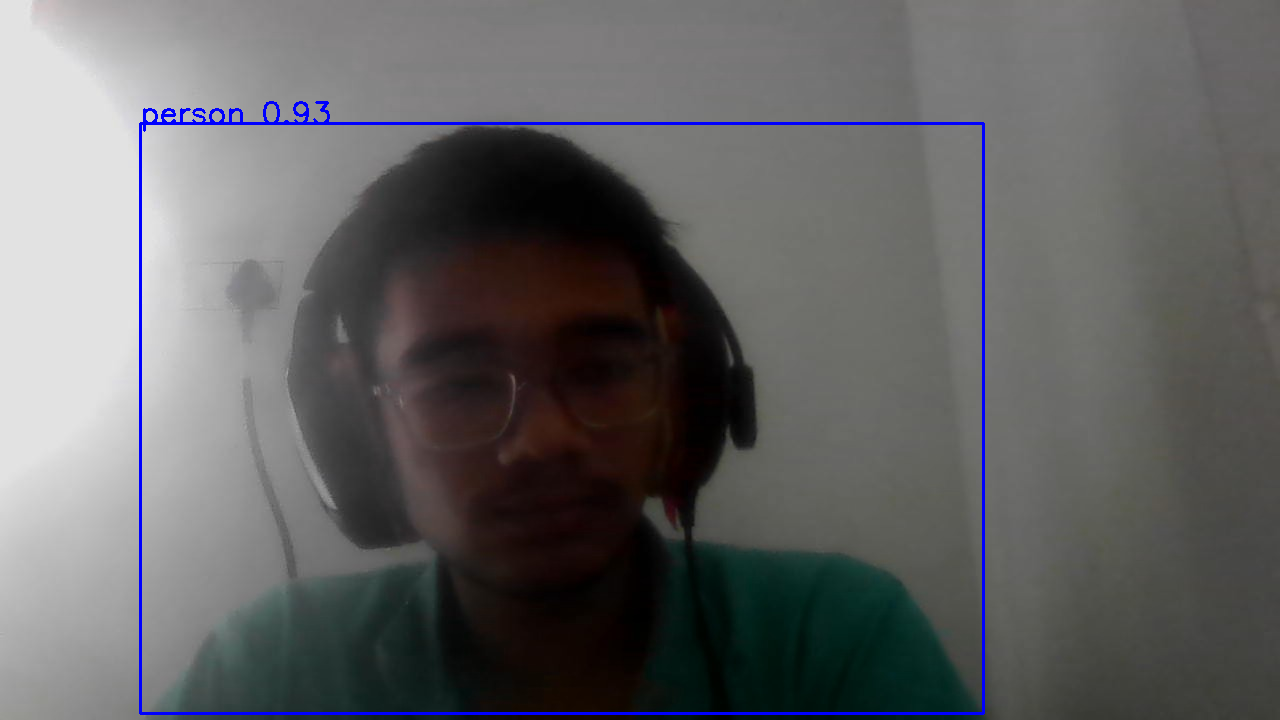

In [ ]:
# ========================
# JavaScript for Camera + Stop Button
# ========================
js_code = '''
function initCamera() {
    return new Promise((resolve, reject) => {
        const video = document.createElement('video');
        video.style.display = 'none';
        document.body.appendChild(video);
        const streamPromise = navigator.mediaDevices.getUserMedia({video: true});
        streamPromise.then((stream) => {
            video.srcObject = stream;
            video.onloadedmetadata = () => {
                resolve(video);
            };
            video.play();
        }).catch((error) => {
            reject(error);
        });
    });
}

async function takePhoto() {
    const video = await initCamera();
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const context = canvas.getContext('2d');
    context.drawImage(video, 0, 0, canvas.width, canvas.height);
    const img = canvas.toDataURL('image/jpeg');
    return img;
}

// Add a stop button to the page
function addStopButton() {
    const button = document.createElement('button');
    button.innerText = "Stop Detection";
    button.style.position = "fixed";
    button.style.top = "10px";
    button.style.right = "10px";
    button.style.zIndex = "1000";
    button.style.padding = "10px";
    button.style.background = "red";
    button.style.color = "white";
    button.style.fontWeight = "bold";
    button.onclick = () => {
        google.colab.kernel.invokeFunction('notebook.stopLoop', [], {});
    };
    document.body.appendChild(button);
}

addStopButton();
'''

from google.colab.output import eval_js
from google.colab import output
import cv2, io, base64, time
import numpy as np
from PIL import Image
from ultralytics import YOLO

# Display JS code (camera + stop button)
display(Javascript(js_code))

# ========================
# Python Helper Functions
# ========================

# Convert JS base64 image to OpenCV format
def js_to_image(js_reply):
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    image_PIL = Image.open(io.BytesIO(image_bytes))
    image_np = np.array(image_PIL)
    frame = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return frame

# Load YOLO model
yolo = YOLO('yolov8s.pt')

# Generate colors for each class
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [base_colors[color_index][i] + increments[color_index][i] *
             (cls_num // len(base_colors)) % 256 for i in range(3)]
    return tuple(color)

# ========================
# Stop Button Handling
# ========================
stop_flag = False
def stop_loop():
    global stop_flag
    stop_flag = True

output.register_callback('notebook.stopLoop', stop_loop)

# ========================
# Detection Loop (every 10 seconds)
# ========================
while True:
    if stop_flag:
        print("Loop stopped by button.")
        break

    js_reply = eval_js('takePhoto()')
    frame = js_to_image(js_reply)

    if frame is None:
        continue

    results = yolo.track(frame, stream=True)

    for result in results:
        classes_names = result.names
        for box in result.boxes:
            if box.conf[0] > 0.4:
                [x1, y1, x2, y2] = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cls = int(box.cls[0])
                class_name = classes_names[cls]
                colour = getColours(cls)
                cv2.rectangle(frame, (x1, y1), (x2, y2), colour, 2)
                cv2.putText(frame, f'{class_name} {box.conf[0]:.2f}',
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, colour, 2)

    # Show the image inside Colab
    from google.colab.patches import cv2_imshow
    cv2_imshow(frame)

    # Wait 10 seconds before next detection
    for i in range(10):
        if stop_flag:
            print("Loop stopped during wait.")
            break
        time.sleep(1)


    if stop_flag:
        break

cv2.destroyAllWindows()
